# Computing the Metric

### Import

In [1]:
%load_ext autoreload
%autoreload 2
from score import *
from plots import *

/Users/leforestierlucas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Training the Parameters

In [10]:
df_sequences = pd.read_csv("sequences.csv")
df_sequences.Game = df_sequences.Game.astype(str)
df_sequences["Time Start"] = df_sequences["Time Start"].astype(str)
df_sequences["Last Touched Player"] = df_sequences["Last Touched Player"].astype(str)
df_sequences

,Game,Period,Time Start,Time Elapsed,Last Touched Player
0,BKN_PHI,2,8:57,1.9,N. Claxton
1,BKN_PHI,2,7:22,2.0,N. Claxton
2,BKN_PHI,3,10:34,2.5,N. Claxton
3,BKN_PHI,3,7:12,2.0,N. Claxton
4,BKN_PHI,4,9:20,2.0,J. Springer
5,BKN_PHI,4,6:46,2.0,T. Smith
6,BKN_PHI,1,2:52,2.0,C. Johnson
7,BKN_PHI,2,11:44,2.7,N. Claxton
8,BKN_PHI,2,5:40,2.5,T. Maxey
9,BKN_PHI,2,0:33,2.0,S. Dinwiddie


In [11]:
def get_sequences(df):
    list_sequences = []
    rows_list = df.values.tolist()
    k = 0
    for row in rows_list:
        print(k)
        data, get_players, raw_data = get_video(row[1], row[2], row[3], f"{row[0]}.jsonl")
        list_sequences.append([data, get_players, raw_data, row[4]])
        k += 1

    return list_sequences

list_sequences = get_sequences(df_sequences)

0
Size of the data is 115 frames
1
Size of the data is 121 frames
2
Size of the data is 151 frames
3
Size of the data is 121 frames
4
Size of the data is 121 frames
5
Size of the data is 121 frames
6
Size of the data is 121 frames
7
Size of the data is 163 frames
8
Size of the data is 151 frames
9
Size of the data is 121 frames
10
Size of the data is 103 frames
11
Size of the data is 103 frames
12
Size of the data is 97 frames
13
Size of the data is 211 frames
14
Size of the data is 241 frames
15
Size of the data is 187 frames
16
Size of the data is 223 frames
17
Size of the data is 241 frames
18
Size of the data is 151 frames
19
Size of the data is 181 frames
20
Size of the data is 91 frames


In [32]:
def get_last_touch(game_sequences, decay, alpha, error_add):
    
    logs = []
    for sequence in game_sequences: 
        data, get_players, raw_data, ground_truth = sequence
        score_clos, stop_index, times = get_score_closeness(data, get_players, error_add = error_add)
        score_sim = get_score_velocity(raw_data)
        score_sim = reshape_score(score_sim, data, get_players, stop_index)
        areas = {}
        for key, value in score_clos.items():
            if all(element == 0 for element in value):
                pass
            else:
                areas[key] = np.sum(area_factored_similarity(value, score_sim[key], times, factor = decay, factor_sim = alpha))
        proba = make_proba(areas)
        last_touch = max(proba, key=proba.get)
        max_proba = proba[last_touch]
        score_label = 1 if last_touch == ground_truth else 0
        score_loss = (1 - max_proba)*score_label + (1 - score_label)
    
        logs.append([score_label, score_loss])

    accuracy = np.sum([x[0] for x in logs])/len(game_sequences)
    loss = np.sum([x[1] for x in logs])/len(game_sequences)
    print(f"param: {decay}, {alpha}, {error_add}")
    print("loss", loss)
    print("accuracy", accuracy)
    return logs, accuracy, loss


In [13]:
decay2 = [0.5, 0.6, 0.7, 0.8, 0.9]
alpha2 = [0, 0.3, 0.5, 0.7, 1, 3, 5]
error_add2 = [0, 0.5, 1.5, 3, 5, 7]

final_scores2 = []
for dec in decay2:
    for alp in alpha2:
        for err in error_add2:
            param_comb = {}
            param_comb["decay"] = dec
            param_comb["alpha"] = alp
            param_comb["error_add"] = err
            score_by_game, accuracy, loss = get_last_touch(list_sequences, dec, alp, err)
            param_comb["score"] = score_by_game
            param_comb["accuracy"] = accuracy
            param_comb["loss"] = loss
            final_scores2.append(param_comb)

param: 0.5, 0, 0
loss 0.016805527942207084
accuracy 0.6190476190476191
param: 0.5, 0, 0.5
loss 0.027863205374017805
accuracy 0.7142857142857143
param: 0.5, 0, 1.5
loss 0.05219007532842773
accuracy 0.8571428571428571
param: 0.5, 0, 3
loss 0.0471298509628702
accuracy 0.9047619047619048
param: 0.5, 0, 5
loss 0.03975440711008266
accuracy 0.9047619047619048
param: 0.5, 0, 7
loss 0.03798580477955324
accuracy 0.9047619047619048
param: 0.5, 0.3, 0
loss 0.06320557713875816
accuracy 0.6666666666666666
param: 0.5, 0.3, 0.5
loss 0.07397078418663733
accuracy 0.7619047619047619
param: 0.5, 0.3, 1.5
loss 0.09893590378696869
accuracy 0.9047619047619048
param: 0.5, 0.3, 3
loss 0.09342446965814108
accuracy 0.9523809523809523
param: 0.5, 0.3, 5
loss 0.10346162529951271
accuracy 0.9523809523809523
param: 0.5, 0.3, 7
loss 0.0396395609219997
accuracy 0.9047619047619048
param: 0.5, 0.5, 0
loss 0.06252633673764714
accuracy 0.6666666666666666
param: 0.5, 0.5, 0.5
loss 0.07311734163172215
accuracy 0.76190476190

In [ ]:
def get_values_with_highest_accuracy(dict_list):
    max_accuracy = float('-inf')
    best_dict = None

    for d in dict_list:
        if d.get("accuracy", 0) > max_accuracy:
            max_accuracy = d["accuracy"]
            best_dict = [d]
        elif d.get("accuracy", 0) == max_accuracy:
            best_dict.append(d)

    return best_dict


In [17]:
best_acc = get_values_with_highest_accuracy(final_scores2)

In [19]:
best_acc

[{'decay': 0.5,
  'alpha': 3,
  'error_add': 3,
  'score': [[1, 0.0],
   [1, 0.03272562509705468],
   [1, 2.6645352591003757e-15],
   [1, 0.03148747607944047],
   [1, 0.07886819893980512],
   [1, 0.0],
   [1, 1.1102230246251565e-16],
   [1, 0.0],
   [1, 3.8471890084768035e-07],
   [1, 0.24142122554266932],
   [1, 0.0],
   [1, 0.0],
   [1, 1],
   [1, 0.0],
   [1, 0.0],
   [1, 0.07854176765344745],
   [1, 0.2307000790367919],
   [1, 0.0],
   [1, 0.0023590952049354907],
   [1, 0.4664781926259687],
   [1, 3.6094091049321264e-08]],
  'accuracy': 1.0,
  'loss': 0.10298009909490989}]

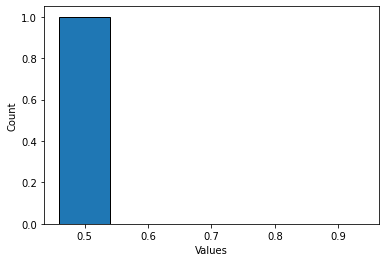

In [18]:
plot_bar([param["decay"] for param in best_acc], decay2)

## Testing Best Parameters (best: 0.5, 3, 3)

In [29]:
test_sequences = pd.read_csv("test_sequences.csv")
test_sequences.Game = test_sequences.Game.astype(str)
test_sequences["Time Start"] = test_sequences["Time Start"].astype(str)
test_sequences["Last Touched Player"] = test_sequences["Last Touched Player"].astype(str)
test_sequences

,Game,Period,Time Start,Time Elapsed,Last Touched Player
0,MIL_BOS,1,10:44,2.0,J. Brown
1,MIL_BOS,1,5:02,3.0,K. Porzingis
2,MIL_BOS,2,2:47,3.0,P. Pritchard
3,MIL_BOS,4,1:47,2.4,D. Banton
4,MIL_BOS,1,0:29,2.4,B. Portis
5,MIL_BOS,3,0:31,2.5,B. Lopez


In [30]:
list_test_sequences = get_sequences(test_sequences)

0
Size of the data is 121 frames
1
Size of the data is 181 frames
2
Size of the data is 181 frames
3
Size of the data is 145 frames
4
Size of the data is 145 frames
5
Size of the data is 151 frames


In [31]:
get_last_touch(list_test_sequences, 0.5, 3, 3)

param: 0.5, 3, 3
loss 0.07908239640817323
accuracy 1.0


([[1, 0.0],
  [1, 0.0023590952049354907],
  [1, 0.4664781926259687],
  [1, 0.0],
  [1, 0.0],
  [1, 0.005657090618135241]],
 1.0,
 0.07908239640817323)